<a href="https://colab.research.google.com/github/RiverGumSecurity/AILabs/blob/dev-derek/labs/Module02_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning and Neural Networks with Phishing Email Data

Neural networks are a subset of machine learning algorithms inspired by the human brain's structure and function. They consist of layers of interconnected "neurons" that transform the input data through weighted connections to produce an output. Neural networks are particularly powerful for complex tasks like image recognition and natural language processing.

Neural networks consist of an input layer, one or more hidden layers, and an output layer. These layers consist of "neurons" where each neuron processes input data by applying a weight and an activation function (like sigmoid or ReLU) to produce an output. The training (or learning) process adjusts the weights of the connections between neurons using algorithms like backpropagation and optimization techniques like gradient descent. Neural networks, particularly deep neural networks (deep learning), can model highly complex relationships between inputs and outputs by learning hierarchical feature representations in the hidden layers. Deep learning neural networks typically contain three or more hidden layers.

<center><img src="https://images.edrawsoft.com/articles/neural-network-diagram/example1.png" width="800" height="600"></center>




In [1]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import plotly.express as px
import datetime
import os 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
import warnings

In [2]:
# Detect GPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13497341992264656472
xla_global_id: -1
]


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

## Dataset

The dataset that will be used to train and test the different models was from https://www.kaggle.com/datasets/subhajournal/phishingemails.  It was pre-labeled as "Safe Email" or "Phishing Email".  The data will be cleaned and prepared for training machine learning models with Pandas.

In [4]:
# Read in the data into a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/RiverGumSecurity/AILabs/main/datasets/Phishing_Email.csv')
#df = pd.read_csv('../datasets/Phishing_Email.csv')
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [5]:
# Print information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [6]:
# Drop null values in place, drop Unamed:0 column, drop duplicates
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [7]:
# Show the shape of the data
df.shape

(17538, 2)

In [8]:
# Display cleaned dataframe
df.head(10)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,re : coastal deal - with exxon participation u...,Safe Email


In [9]:
# Display the count of Email types, a Safe Email or a Phishing Email
df['Email Type'].value_counts()

Email Type
Safe Email        10980
Phishing Email     6558
Name: count, dtype: int64

<Axes: xlabel='Email Type'>

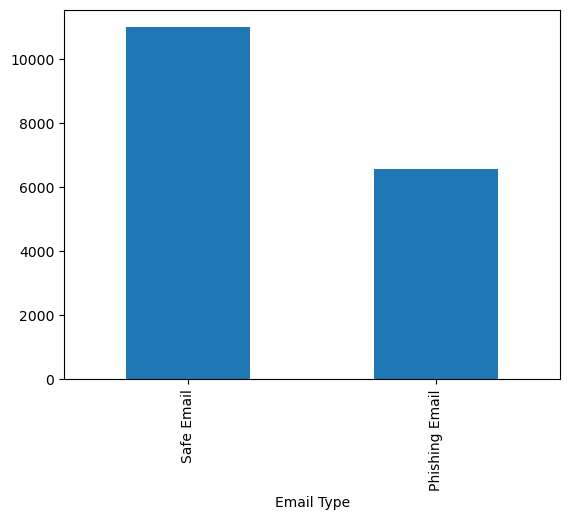

In [10]:
# Plot counts of Safe Email vs Phishing Email
df['Email Type'].value_counts().plot(kind='bar')

Now we need to further process and clean the data. This is a binary classification problem, and we need to assign a label (a 1 or a 0) to the email categories. Then we will remove URLS and non word characters from the emails - we are interested in the similarities of the text itself.  Then we lowercase all of the characters, convert all multiple whitespace characters to single whitespace, and remove any trailing whitespaces.

In [11]:
# Label Email Type
lbl = LabelEncoder()
df['Email Type'] = lbl.fit_transform(df['Email Type'])

In [12]:
# Function to preprocess text.
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Email Text']=df['Email Text'].apply(preprocess_text)

In [13]:
df.head(10)

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0
5,global risk management operations sally congra...,1
6,on sun aug 11 2002 at 111747am 0100 wintermute...,1
7,entourage stockmogul newsletter ralph velez ge...,0
8,we owe you lots of money dear applicant after ...,0
9,re coastal deal with exxon participation under...,1


## Neural Networks

In [14]:
max_len = 150 #Fixed the length of each vector

tk = Tokenizer()

# Process the text

tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [15]:
len(vector)

17538

In [16]:
len(tk.word_index) + 1

182317

In [17]:
max_features=10000

In [18]:
#convert feature vector and label into array
X = np.array(vector)
y = np.array(df['Email Type'])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

In [20]:
model_srnn = Sequential() # Sequential() API
model_srnn.add(Embedding(len(tk.word_index)+1,50))
model_srnn.add(SimpleRNN(units=100))
model_srnn.add(Dropout(0.5))
model_srnn .add(Dense(1, activation='sigmoid'))

In [21]:
model_srnn.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [22]:
historical_srnn  = model_srnn.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 [==============================] - 22s 25ms/step - loss: 0.6689 - accuracy: 0.6058 - val_loss: 0.6426 - val_accuracy: 0.6194
Epoch 2/20
877/877 [==============================] - 22s 25ms/step - loss: 0.6015 - accuracy: 0.6574 - val_loss: 0.5407 - val_accuracy: 0.6890
Epoch 3/20
877/877 [==============================] - 22s 25ms/step - loss: 0.4670 - accuracy: 0.7342 - val_loss: 0.5206 - val_accuracy: 0.7124
Epoch 4/20
877/877 [==============================] - 22s 25ms/step - loss: 0.4258 - accuracy: 0.7623 - val_loss: 0.5667 - val_accuracy: 0.6474
Epoch 5/20
877/877 [==============================] - 22s 25ms/step - loss: 0.4866 - accuracy: 0.7242 - val_loss: 0.5361 - val_accuracy: 0.6861
Epoch 6/20
877/877 [==============================] - 22s 25ms/step - loss: 0.4539 - accuracy: 0.7360 - val_loss: 0.5443 - val_accuracy: 0.6223
Epoch 7/20
877/877 [==============================] - 22s 25ms/step - loss: 0.4259 - accuracy: 0.7495 - val_loss: 0.5570 - val_accuracy:

Text(0, 0.5, 'Loss')

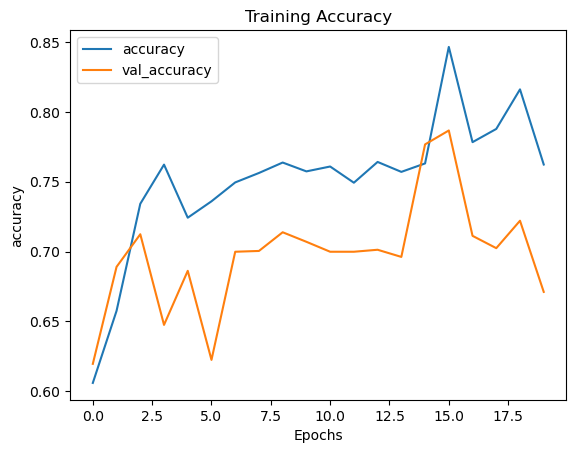

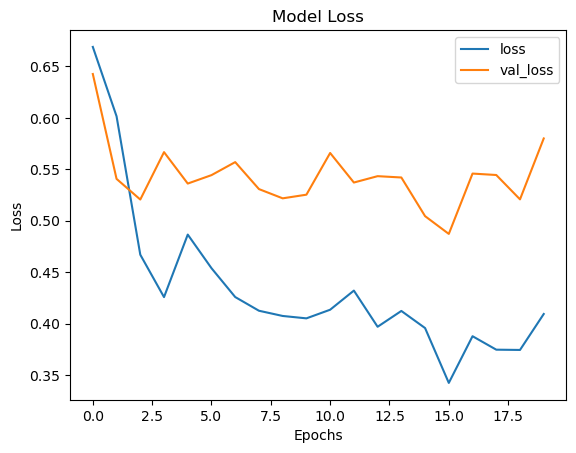

In [23]:

pd.DataFrame(historical_srnn.history)

pd.DataFrame(historical_srnn.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_srnn.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

110/110 [==============================] - 1s 5ms/step


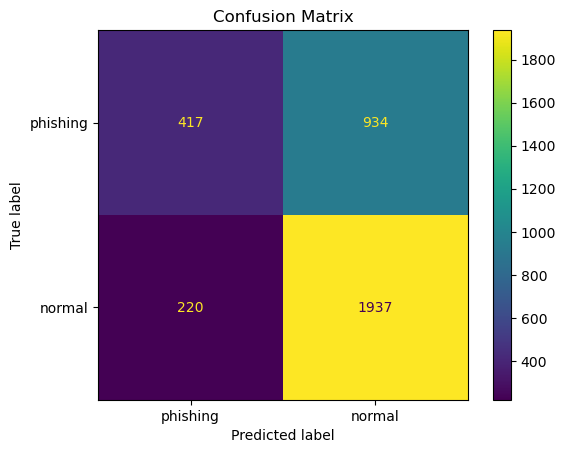

In [24]:
y_pred_prob_smp = model_srnn.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)


cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['phishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Evaluate the model on the test set
srnn_loss, srnn_accu = model_srnn.evaluate(x_test, y_test, verbose=0)

srnn_accu = (srnn_accu*100)

# Display the accuracy value
print(f'The accuracy of the SRNN model on the test data set was: {srnn_accu:.4f}')

The accuracy of the SRNN model on the test data set was: 67.1038


## LTSM

In [26]:
model_lstm = Sequential() # Sequential() API
model_lstm.add(Embedding(len(tk.word_index)+1,50))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

In [27]:
model_lstm.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [28]:
historical_lstm  = model_lstm.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 [==============================] - 58s 66ms/step - loss: 0.3853 - accuracy: 0.8246 - val_loss: 0.1775 - val_accuracy: 0.9478
Epoch 2/20
877/877 [==============================] - 57s 65ms/step - loss: 0.3111 - accuracy: 0.8783 - val_loss: 0.2331 - val_accuracy: 0.9247
Epoch 3/20
877/877 [==============================] - 58s 66ms/step - loss: 0.3000 - accuracy: 0.8957 - val_loss: 0.3092 - val_accuracy: 0.8865
Epoch 4/20
877/877 [==============================] - 58s 66ms/step - loss: 0.1919 - accuracy: 0.9356 - val_loss: 0.2099 - val_accuracy: 0.9390
Epoch 5/20
877/877 [==============================] - 57s 65ms/step - loss: 0.1184 - accuracy: 0.9720 - val_loss: 0.1715 - val_accuracy: 0.9544
Epoch 6/20
877/877 [==============================] - 57s 65ms/step - loss: 0.0931 - accuracy: 0.9787 - val_loss: 0.1551 - val_accuracy: 0.9601
Epoch 7/20
877/877 [==============================] - 57s 65ms/step - loss: 0.1315 - accuracy: 0.9584 - val_loss: 0.4142 - val_accuracy:

In [29]:
lstm_results = model_lstm.evaluate(x_test, y_test)
lstm_loss = lstm_results[0]  # Extract the loss from the results
lstm_accu = (lstm_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {lstm_loss}")
print(f"Model Accuracy: {lstm_accu}")

110/110 [==============================] - 3s 27ms/step - loss: 0.1853 - accuracy: 0.9666
Model Loss: 0.1852756291627884
Model Accuracy: 96.66476845741272


In [30]:
y_pred_prob = model_lstm.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 [==============================] - 3s 28ms/step


Text(0, 0.5, 'Loss')

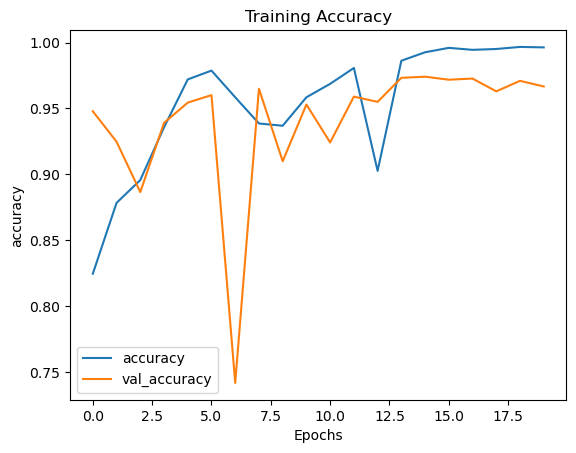

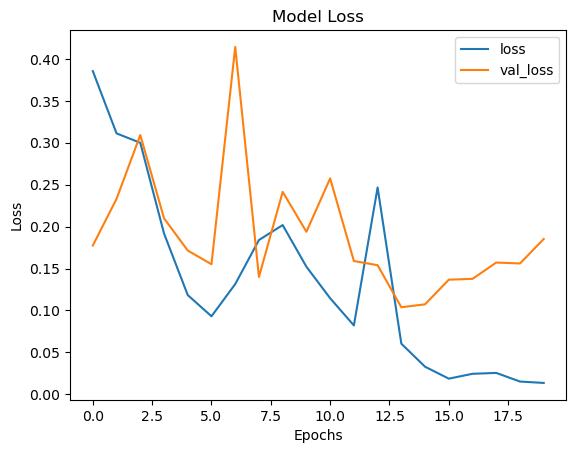

In [31]:
pd.DataFrame(historical_lstm.history)

pd.DataFrame(historical_lstm.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_lstm.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

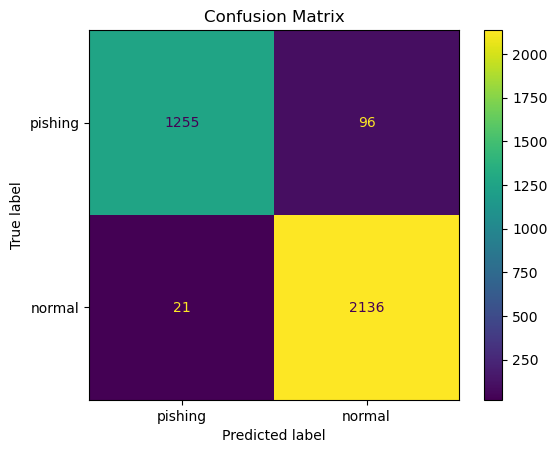

In [32]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['pishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

## Bidirectional

In [33]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(len(tk.word_index)+1,50))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [34]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [35]:
historical_bi  = model_bi.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 [==============================] - 93s 104ms/step - loss: 0.2030 - accuracy: 0.9175 - val_loss: 0.1305 - val_accuracy: 0.9453
Epoch 2/20
877/877 [==============================] - 121s 138ms/step - loss: 0.0539 - accuracy: 0.9827 - val_loss: 0.1185 - val_accuracy: 0.9701
Epoch 3/20
877/877 [==============================] - 101s 115ms/step - loss: 0.0174 - accuracy: 0.9956 - val_loss: 0.0708 - val_accuracy: 0.9789
Epoch 4/20
877/877 [==============================] - 107s 122ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.0862 - val_accuracy: 0.9758
Epoch 5/20
877/877 [==============================] - 106s 121ms/step - loss: 0.0103 - accuracy: 0.9970 - val_loss: 0.1247 - val_accuracy: 0.9678
Epoch 6/20
877/877 [==============================] - 927s 1s/step - loss: 0.0209 - accuracy: 0.9944 - val_loss: 0.1446 - val_accuracy: 0.9644
Epoch 7/20
877/877 [==============================] - 101s 115ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0974 - val

In [36]:
bi_results = model_bi.evaluate(x_test, y_test)
bi_loss = bi_results[0]  # Extract the loss from the results
bi_accu = (bi_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {bi_loss}")
print(f"Model Accuracy: {bi_accu}")

110/110 [==============================] - 6s 56ms/step - loss: 0.1345 - accuracy: 0.9769
Model Loss: 0.1344664841890335
Model Accuracy: 97.69099354743958


In [37]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

110/110 [==============================] - 6s 55ms/step


Text(0, 0.5, 'Loss')

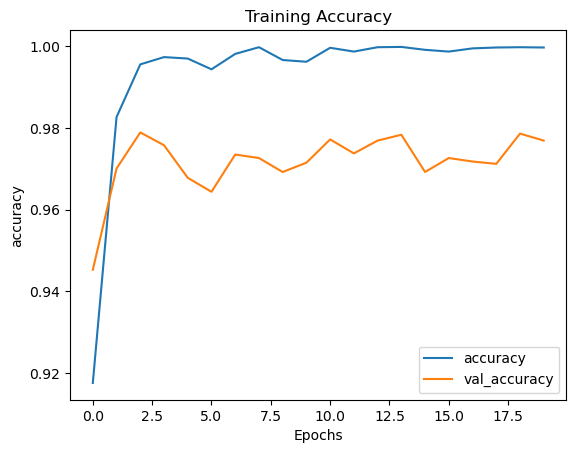

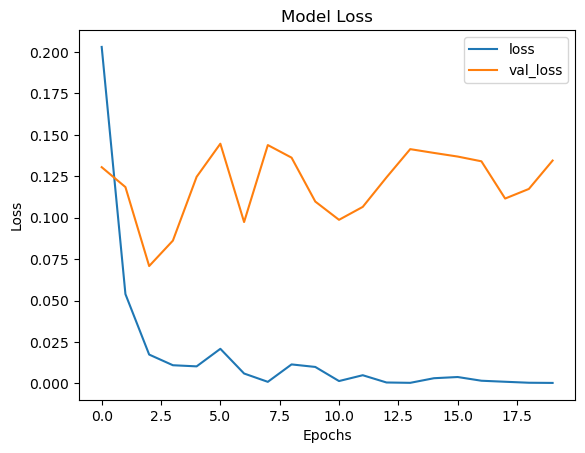

In [38]:
pd.DataFrame(historical_bi.history)

pd.DataFrame(historical_bi.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_bi.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

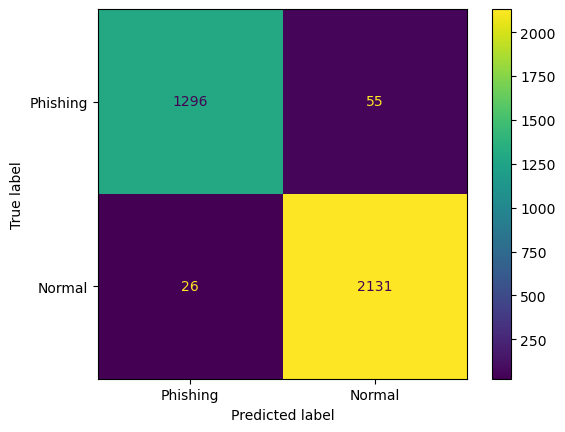

In [39]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Phishing','Normal'])
ax_bi.plot()
plt.show()

### Gated Recurrent Unit

In [40]:
model_gru = Sequential() # Sequential() API
model_gru.add(Embedding(len(tk.word_index)+1,50))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

In [41]:
model_gru.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [42]:
historical_gru = model_gru.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 [==============================] - 70s 79ms/step - loss: 0.4899 - accuracy: 0.7745 - val_loss: 0.2742 - val_accuracy: 0.9128
Epoch 2/20
877/877 [==============================] - 68s 78ms/step - loss: 0.1747 - accuracy: 0.9449 - val_loss: 0.1364 - val_accuracy: 0.9584
Epoch 3/20
877/877 [==============================] - 1924s 2s/step - loss: 0.0851 - accuracy: 0.9759 - val_loss: 0.1308 - val_accuracy: 0.9624
Epoch 4/20
877/877 [==============================] - 69s 79ms/step - loss: 0.1007 - accuracy: 0.9713 - val_loss: 0.0955 - val_accuracy: 0.9726
Epoch 5/20
877/877 [==============================] - 69s 78ms/step - loss: 0.0290 - accuracy: 0.9922 - val_loss: 0.0720 - val_accuracy: 0.9798
Epoch 6/20
877/877 [==============================] - 68s 77ms/step - loss: 0.0121 - accuracy: 0.9974 - val_loss: 0.0728 - val_accuracy: 0.9832
Epoch 7/20
877/877 [==============================] - 69s 79ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0799 - val_accuracy:

In [43]:
gru_results = model_gru.evaluate(x_test, y_test)
gru_loss = gru_results[0]  # Extract the loss from the results
gru_accu = (gru_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {gru_loss}")
print(f"Model Accuracy: {gru_accu}")

110/110 [==============================] - 3s 27ms/step - loss: 0.1120 - accuracy: 0.9812
Model Loss: 0.1119622066617012
Model Accuracy: 98.11858534812927


In [44]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

110/110 [==============================] - 3s 28ms/step


Text(0, 0.5, 'Loss')

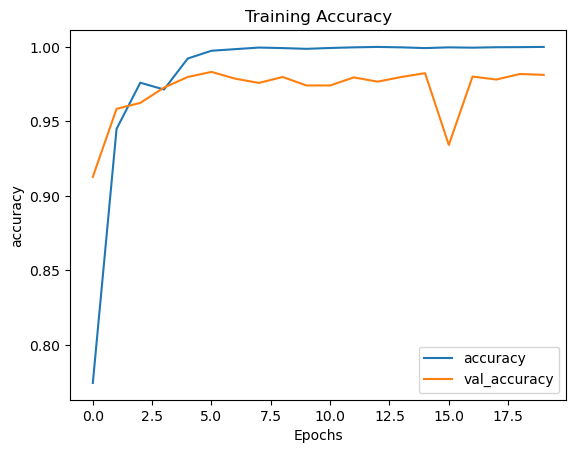

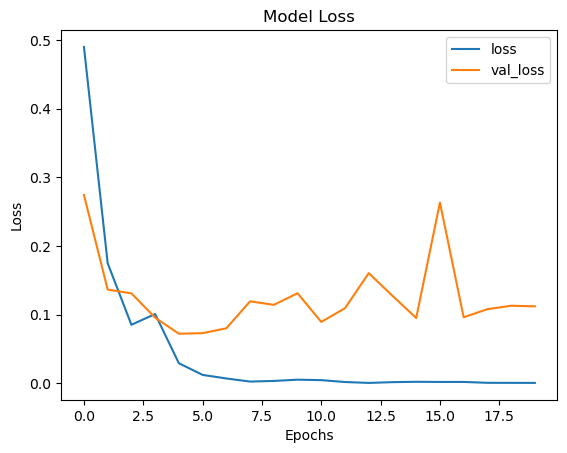

In [45]:
pd.DataFrame(historical_gru.history)

pd.DataFrame(historical_gru.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_gru.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

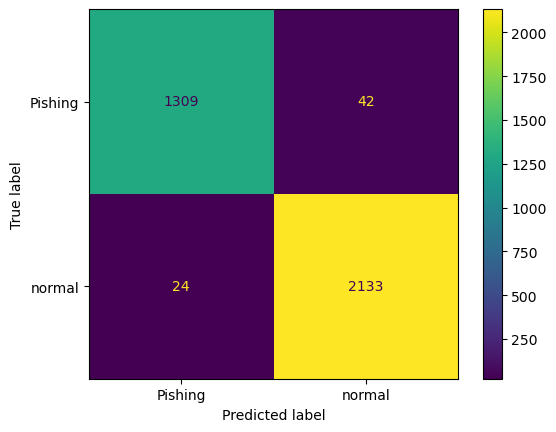

In [46]:
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(confusion_matrix=cnf_gru,display_labels=['Pishing','normal'])
ax_gru.plot()
plt.show()

# Model Comparisons

In [48]:
# Need to do - set up table of models and comparisons

accu_values = [srnn_accu,lstm_accu, bi_accu, gru_accu]
row_labels = ["Simple RNN", "LSTM Neural Network", "Bidirectional Neural Network", "Gated Recurrent Unit"]
comp_df = pd.DataFrame(accu_values, columns=["accuracy"], index=row_labels)
print(comp_df)

                               accuracy
Simple RNN                    67.103761
LSTM Neural Network           96.664768
Bidirectional Neural Network  97.690994
Gated Recurrent Unit          98.118585
